# Generative Adversarial Network

data provided by  https://quickdraw.withgoogle.com/

adverisal network example

* generator creates images from random noise
* discriminator check images if they are produced from noise or real images
* adversarial network(gen+disc) runs on frozen discriminator parameters using discriminator parameters obtained from the previous state. So  to adv net again random noise is given as input and they are labeled as real images so the disc params are not updateble and they tend to predict fake images as fake even though they are labeled a real. Then in order to reduce the loss generator parameters are getting updated in a way to reduce the loss therefore producing more realistic images from noise

#### dependencies

In [1]:
import numpy as np
import os

import keras
from keras import Sequential, Model
from keras.layers import Input, Dense, Conv2D, BatchNormalization, Dropout, Flatten
from keras.layers import Activation, Reshape, Conv2DTranspose, UpSampling2D
from keras.optimizers import RMSprop

import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


#### load data

In [2]:
input_images = './bulldozer.npy'
data = np.load(input_images)

In [3]:
data.shape # images are already flattened 28 by 28 bw to 784
#255 black 0 white

(187409, 784)

#### reshape data

In [4]:
data=data/255 # normalize pixels

In [5]:
data.shape[0]

187409

In [6]:
data = np.reshape(data,(data.shape[0],28,28,1)) # data, num of images, width, heigth, channels

In [7]:
img_w,img_h = data.shape[1:3]

In [8]:
data.shape

(187409, 28, 28, 1)

[147014 151479  56296 157134  12996 177584 142491  61761 118553]
0 0 0
1 1 0
2 2 0
3 0 1
4 1 1
5 2 1
6 0 2
7 1 2
8 2 2


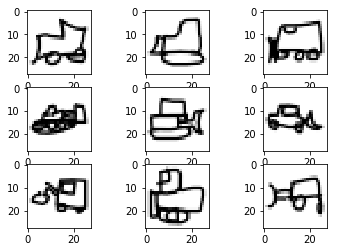

In [9]:
import math
fig,axes = plt.subplots(3,3)

l = np.random.choice(data.shape[0], 9)
print(l)
m = 0
for k in l:
    r = m%3
    c = math.floor((m)/3)
    print(m,r,c)
    axes[r,c].imshow(data[k,:,:,0],cmap='Greys')
    m +=1

### Discriminator Network
it labels images as fake or real

In [10]:
def discriminator_builder(width=64,p=0.4):
    # define inputs
    inputs = Input((img_w,img_h,1))
    # conv layers
    conv1 = Conv2D(width*1, 5, strides=2, padding='same', activation = 'relu')(inputs)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(width*2, 5, strides=2, padding='same', activation = 'relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    #conv3 = Conv2D(width*4, 5, strides=2, padding='same', activation = 'relu')(conv2)
    #conv3 = Dropout(p)(conv3)
    
    #conv4 = Conv2D(width*8, 5, strides=1, padding='same', activation = 'relu')(conv3)
    #conv4 = Dropout(p)(conv4)
    conv4 = Flatten()(conv2)
    
    output = Dense(1, activation='sigmoid')(conv4)
    # model
    model = Model(inputs=inputs,outputs = output)
    model.summary()
    return model

In [11]:
discriminator = discriminator_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6273      
Total para

In [12]:
discriminator.compile(loss='binary_crossentropy',
                     optimizer=RMSprop(lr=0.0008, decay=6e-8, clipvalue=1.0),
                     metrics=['accuracy'])

###  Generator Network
creates fake images

In [15]:
def generator_builder(z_dim=100, depth=32, p=0.4):
    #define input
    inputs = Input((z_dim,))
    #dense layers
    d1 = Dense(7*7*32)(inputs) # image to be createat is 7 by 7
    d1 = BatchNormalization(momentum=0.9,name='bn0')(d1)
    d1 = Activation(activation='relu')(d1) # so that bn happens before activation
    d1 = Reshape((7,7,32))(d1) # 7by 7 shape with depth of 64
    d1 = Dropout(p)(d1)
    
    # deconv layers
    d2 = UpSampling2D()(d1)
    d2 = Conv2DTranspose(int(depth/2),kernel_size = 5, padding='same',activation=None)(d2)
    d2 = BatchNormalization(momentum=0.9,name='bn')(d2)
    d2 = Activation(activation='relu')(d2)
    
    d3 = UpSampling2D()(d2)
    d3 = Conv2DTranspose(int(depth/4),kernel_size = 5, padding='same',activation=None)(d3)
    d3 = BatchNormalization(momentum=0.9)(d3)
    d3 = Activation(activation='relu')(d3)
    
   
    #d4 = Conv2DTranspose(int(depth/8),kernel_size = 5, padding='same',activation=None)(d3)
    #d4 = BatchNormalization(momentum=0.9)(d4)
    #d4 = Activation(activation='relu')(d4)
    
    # output
    output = Conv2D(1,kernel_size =5, padding='same', activation='sigmoid')(d3)
    
    model = Model(inputs=inputs,outputs = output)
    model.summary()
    return model

In [16]:
generator = generator_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1568)              158368    
_________________________________________________________________
bn0 (BatchNormalization)     (None, 1568)              6272      
_________________________________________________________________
activation_2 (Activation)    (None, 1568)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 32)        0         
__________

### Generative Adverserial Network

In [17]:
def adversarial_builder(z_dim=100):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    model.compile(loss='binary_crossentropy',
                 optimizer=RMSprop(lr=0.0004,decay=3e-8, clipvalue=1.0),
                 metrics=['accuracy'])
    model.summary()
    return model

In [18]:
import tensorflow as tf
tf.get_variable_scope().reuse_variables()

In [19]:
adv_model = adversarial_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 28, 28, 1)         180961    
_________________________________________________________________
model_1 (Model)              (None, 1)                 212865    
Total params: 393,826
Trainable params: 390,642
Non-trainable params: 3,184
_________________________________________________________________


###  Training

In [20]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable =  val

In [21]:
def train(epochs=2000,batch=128):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        if i%100 == 0:
            print(i)
        
        real_imgs = np.reshape(data[np.random.choice(data.shape[0],batch,replace=False)],(batch,28,28,1))
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, 100]))

        x = np.concatenate((real_imgs,fake_imgs))
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        # make dicriminator layers untrainable
        make_trainable(discriminator, True)
        # train a model discriminating true images from noise
        d_metrics.append(discriminator.train_on_batch(x,y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        # make dicriminator layers untrainable
        make_trainable(discriminator, False)
        # create noise
        noise = np.random.uniform(-1.0, 1.0, size=[batch, 100])
        y = np.ones([batch,1])
        # train adv model where discriminator paramters are freezed
        a_metrics.append(adv_model.train_on_batch(noise,y)) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        if (i+1)%500 == 0:

            print('Epoch #{}'.format(i+1))
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

0


C:\Anaconda\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100
200
300
400
Epoch #500
499: [D loss: 0.530802, acc: 0.771120]  [A loss: 2.235169, acc: 0.187516]


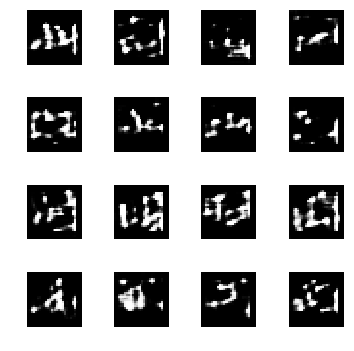

500
600
700
800
900
Epoch #1000
999: [D loss: 0.582092, acc: 0.719215]  [A loss: 2.013355, acc: 0.202116]


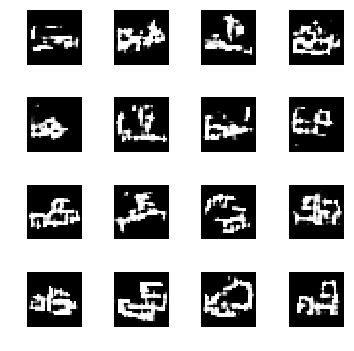

1000
1100
1200
1300
1400
Epoch #1500
1499: [D loss: 0.576688, acc: 0.714119]  [A loss: 1.923204, acc: 0.193384]


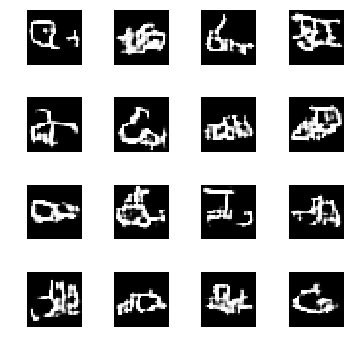

1500
1600
1700
1800
1900
Epoch #2000
1999: [D loss: 0.573875, acc: 0.712002]  [A loss: 1.928130, acc: 0.192964]


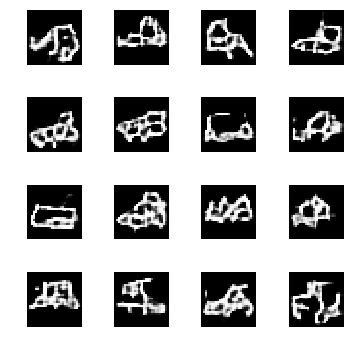

2000
2100
2200
2300
2400
Epoch #2500
2499: [D loss: 0.571634, acc: 0.712379]  [A loss: 1.931053, acc: 0.191248]


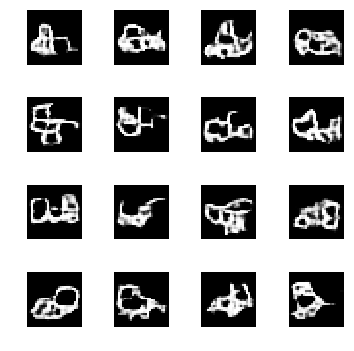

2500
2600
2700
2800
2900
Epoch #3000
2999: [D loss: 0.567206, acc: 0.714577]  [A loss: 1.936290, acc: 0.191447]


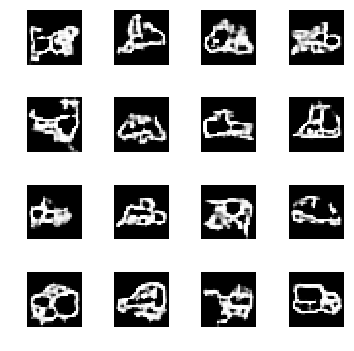

In [22]:
a_metrics_complete, d_metrics_complete = train(epochs=3000)